In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from skimage.draw import disk
from skimage.segmentation import flood_fill
from skimage.segmentation import find_boundaries
from skimage.draw import polygon
from scipy.ndimage import binary_dilation

C:\Users\devra\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
directory = [r'C:\Users\devra\OneDrive\Desktop\5505 ML\Dataset 3\brainTumorDataPublic_1-766'
            ,r'C:\Users\devra\OneDrive\Desktop\5505 ML\Dataset 3\brainTumorDataPublic_767-1532'
            ,r'C:\Users\devra\OneDrive\Desktop\5505 ML\Dataset 3\brainTumorDataPublic_1533-2298'
            ,r'C:\Users\devra\OneDrive\Desktop\5505 ML\Dataset 3\brainTumorDataPublic_2299-3064']

In [3]:
# Create a list to store the loaded data from all files
all_data = []
segmented_tumor_data=[]
# Iterate through the .mat files in the directory
for each_dir in directory:
    for filename in os.listdir(each_dir):
        if filename.endswith('.mat'):
            # Construct the full file path
            file_path = os.path.join(each_dir, filename)

            # Load the .mat file using h5py
            with h5py.File(file_path, 'r') as file:
                # Access the data fields within the HDF5 dataset
                label = file['cjdata']['label'][0, 0]
                patient_id = file['cjdata']['PID'][0, 0]
                image_data = file['cjdata']['image'][:]
                tumor_border = file['cjdata']['tumorBorder'][:]
                tumor_mask = file['cjdata']['tumorMask'][:]
                segmented_tumor_data.append(np.where(tumor_mask == 1,image_data, 0))

                # Append the loaded data to the list
                all_data.append({
                    'label': label,
                    'patient_id': patient_id,
                    'image_data': image_data,
                    'tumor_border': tumor_border,
                    'tumor_mask': tumor_mask
                })


Resizing Images and Masks
First, ensure that all images and masks are of the same size. Deep learning models require consistent input dimensions. If your images are of different sizes, resize them to a consistent shape. For example, if you choose to resize your images to 128x128 pixels:

In [4]:
import numpy as np
import cv2

resized_images = []
resized_masks = []

for data in all_data:
    image = data['image_data']
    mask = data['tumor_mask']

    # Resize image and mask
    resized_image = cv2.resize(image, (128, 128))
    resized_mask = cv2.resize(mask, (128, 128))

    resized_images.append(resized_image)
    resized_masks.append(resized_mask)

resized_images = np.array(resized_images)
resized_masks = np.array(resized_masks)


resized_images = resized_images / 255.0


In [5]:
resized_images = resized_images / 255.0


Preparing Masks
Ensure that your masks are binary (i.e., they contain only 0s and 1s). If they're not already binary, you can convert them:

In [6]:
resized_masks = resized_masks / np.max(resized_masks)
resized_masks[resized_masks > 0.5] = 1
resized_masks[resized_masks <= 0.5] = 0


Splitting the Data into Training and Testing Sets
Use a library like sklearn to split your dataset into training and testing sets:



In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(resized_images, resized_masks, test_size=0.1, random_state=42)


Reshaping for Model Input
Finally, ensure that your data is in the correct shape expected by the model. For most CNNs, including U-Net, you'll need your data in the shape (samples, height, width, channels). If your images are grayscale, they still need a channel dimension:

In [8]:
X_train = np.expand_dims(X_train, axis=-1)  # Adding a channel dimension
X_test = np.expand_dims(X_test, axis=-1)
Y_train = np.expand_dims(Y_train, axis=-1)
Y_test = np.expand_dims(Y_test, axis=-1)




Now that our data is preprocessed and ready, the next steps involve building and training our segmentation model. Let's proceed with these steps:

1. Building the U-Net Model
The U-Net architecture is particularly effective for image segmentation tasks. It has a symmetric structure with a contracting path to capture context and a symmetric expanding path that enables precise localization.

Here's a basic U-Net implementation in TensorFlow:

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Contracting Path (Encoder)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)

    # Expansive Path (Decoder)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Define input shape and create the model
input_shape = (128, 128, 1)  # Adjust the input shape as per your dataset
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 32)           4640      ['max_pooling2d[0][0]'] 

U-Net model has been successfully created. The model summary shows the layers of the network, their types, output shapes, and the number of parameters in each layer. The total number of trainable parameters is 958,577, which is a typical size for a U-Net model.

In [10]:
# Replace 'X_train', 'Y_train', 'X_test', and 'Y_test' with your dataset variables
history = model.fit(X_train, Y_train, batch_size=32, epochs=20, validation_data=(X_test, Y_test))

Epoch 1/20


87/87 [==============================] - 19s 159ms/step - loss: 0.1270 - accuracy: 0.9779 - val_loss: 0.0644 - val_accuracy: 0.9835
Epoch 2/20
87/87 [==============================] - 13s 144ms/step - loss: 0.0587 - accuracy: 0.9826 - val_loss: 0.0522 - val_accuracy: 0.9835
Epoch 3/20
87/87 [==============================] - 13s 146ms/step - loss: 0.0512 - accuracy: 0.9829 - val_loss: 0.0442 - val_accuracy: 0.9846
Epoch 4/20
87/87 [==============================] - 13s 150ms/step - loss: 0.0463 - accuracy: 0.9836 - val_loss: 0.0434 - val_accuracy: 0.9852
Epoch 5/20
87/87 [==============================] - 13s 149ms/step - loss: 0.0403 - accuracy: 0.9852 - val_loss: 0.0378 - val_accuracy: 0.9866
Epoch 6/20
87/87 [==============================] - 13s 147ms/step - loss: 0.0338 - accuracy: 0.9873 - val_loss: 0.0341 - val_accuracy: 0.9880
Epoch 7/20
87/87 [==============================] - 13s 148ms/step - loss: 0.0296 - accuracy: 0.9888 - val_loss: 0.0351 - val_accuracy: 0.98

In [11]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

10/10 [==============================] - 1s 47ms/step - loss: 0.0339 - accuracy: 0.9918
Test Loss: 0.03388875722885132, Test Accuracy: 0.991814136505127


In [13]:
model.save("unet_model.h5")  # Save the trained model to a file


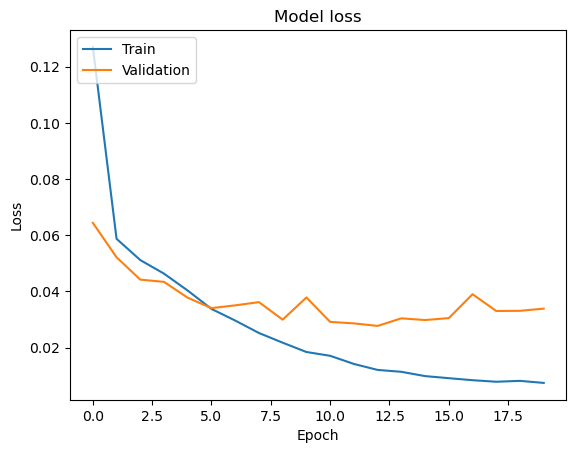

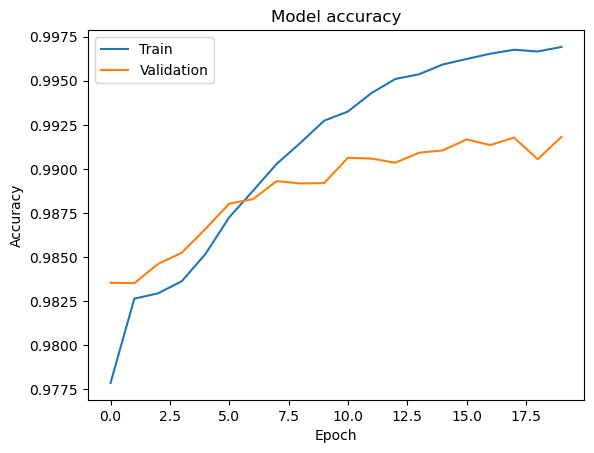

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [16]:
# Predict on the test set
Y_pred = model.predict(X_test)
Y_pred_binary = (Y_pred > 0.5).astype(np.uint8)  # Convert probabilities to binary values


10/10 [==============================] - 1s 45ms/step


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Reshape the prediction and test masks to a 1D array
Y_pred_binary_reshaped = Y_pred_binary.reshape(-1)
Y_test_reshaped = Y_test.reshape(-1)

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_test_reshaped, Y_pred_binary_reshaped)

# Generate classification report
class_report = classification_report(Y_test_reshaped, Y_pred_binary_reshaped)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[4933903   13224]
 [  27950   54811]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00   4947127
         1.0       0.81      0.66      0.73     82761

    accuracy                           0.99   5029888
   macro avg       0.90      0.83      0.86   5029888
weighted avg       0.99      0.99      0.99   5029888



**Confusion Matrix Analysis**

True Negatives (TN): 4,933,903 - The number of non-tumor pixels correctly identified.

False Positives (FP): 13,224 - Non-tumor pixels incorrectly identified as tumor.

False Negatives (FN): 27,950 - Tumor pixels missed by the model.

True Positives (TP): 54,811 - Tumor pixels correctly identified.

**Classification Report Analysis**

Precision (Class 0): 0.99 - Of all pixels predicted as non-tumor, 99% were correct.

Precision (Class 1): 0.81 - Of all pixels predicted as tumor, 81% were correct.

Recall (Class 0): 1.00 - The model correctly identified 100% of the non-tumor pixels.

Recall (Class 1): 0.66 - The model correctly identified 66% of the tumor pixels.

F1-Score (Class 0): 1.00 - High F1 score for non-tumor class indicating good balance between precision and recall.

F1-Score (Class 1): 0.73 - Moderately high F1 score for tumor class, but there's room for improvement.

Accuracy: 0.99 - Overall, the model correctly classified 99% of the pixels.

10/10 [==============================] - 1s 48ms/step


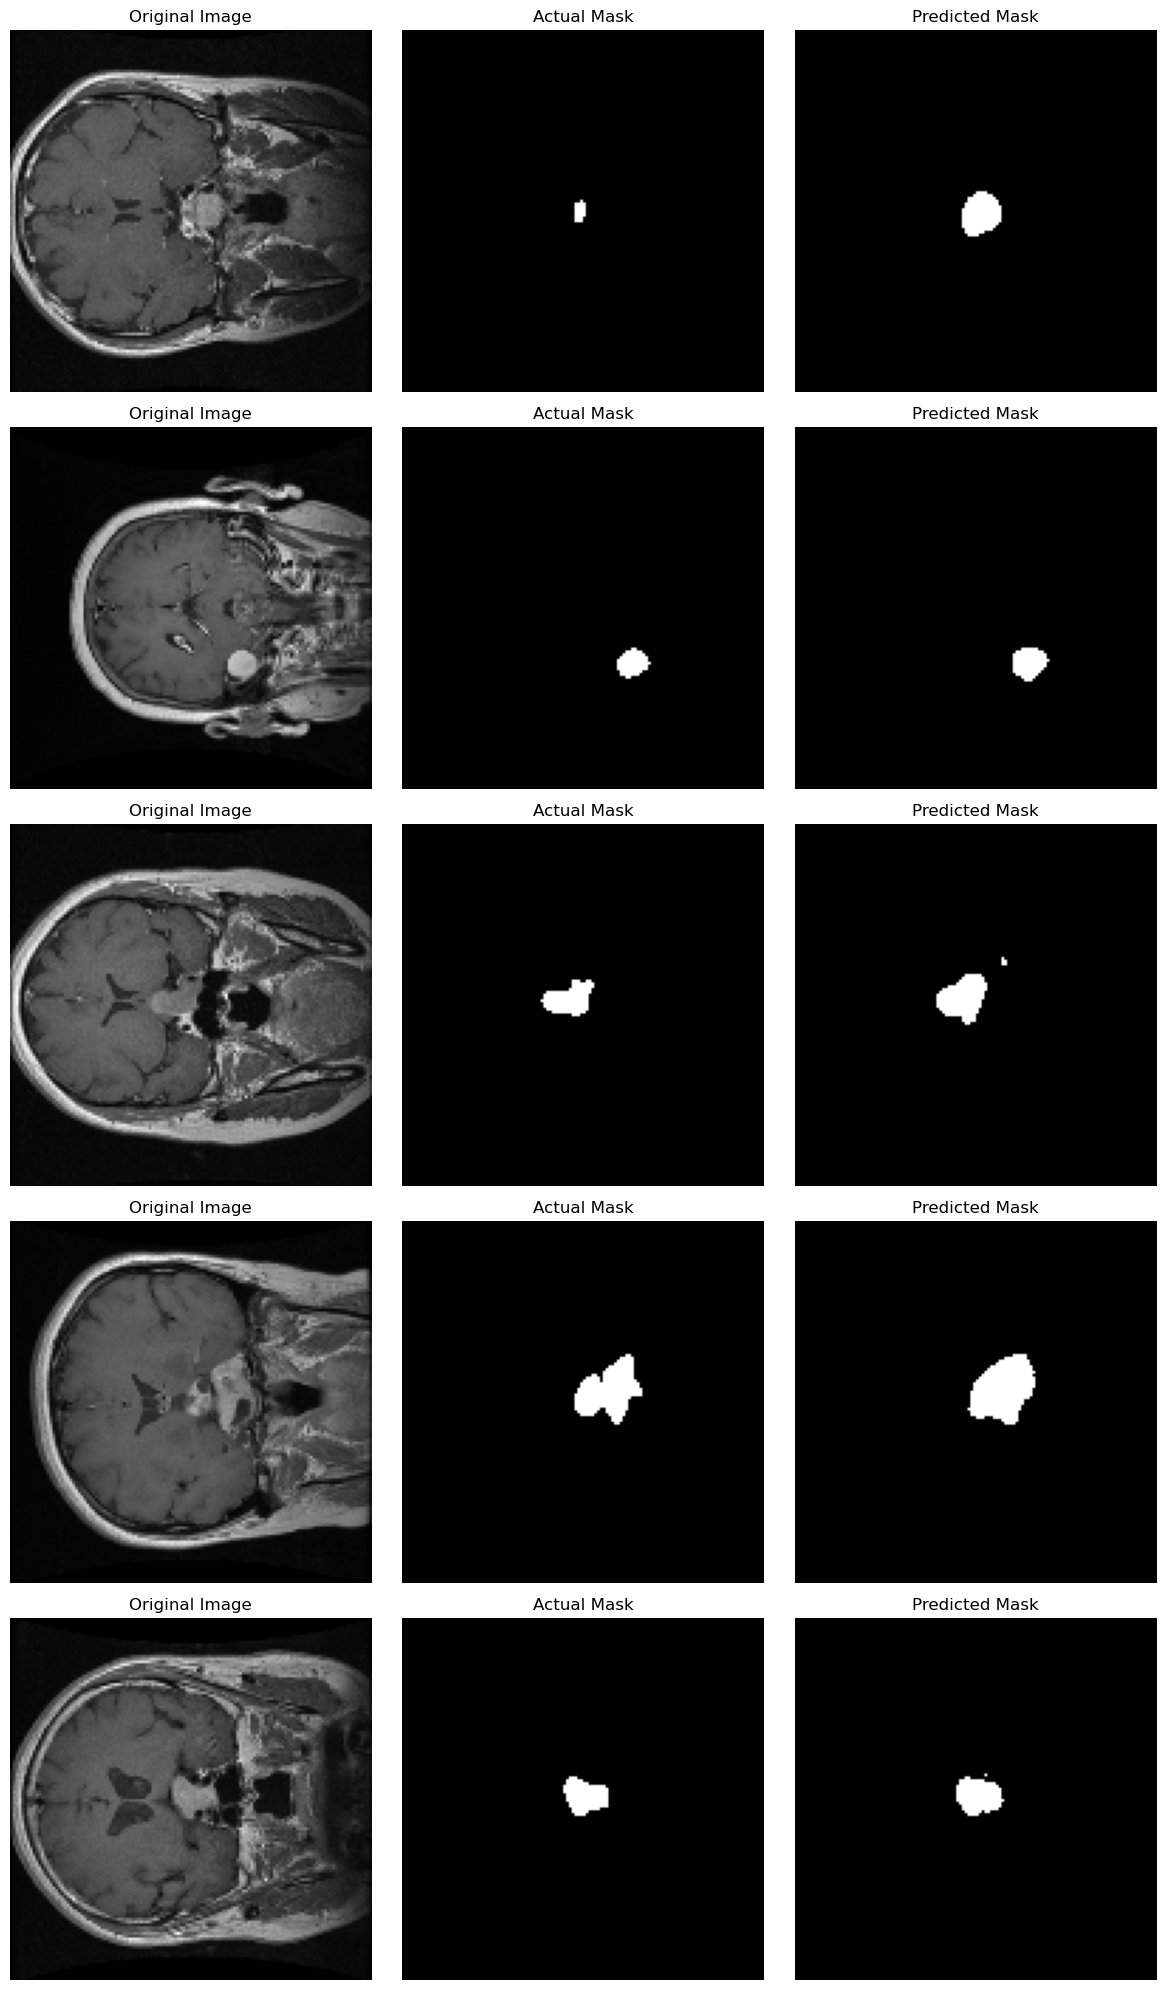

In [22]:
import matplotlib.pyplot as plt

def plot_predictions(X, Y_true, model, num_images=5):
    # Generate predictions
    Y_pred = model.predict(X)

    # Process predictions (convert probabilities to binary values)
    Y_pred_processed = (Y_pred > 0.5).astype('int32')

    plt.figure(figsize=(12, num_images * 4))
    
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(X[i, :, :, 0], cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(Y_true[i, :, :, 0], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(Y_pred_processed[i, :, :, 0], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_predictions(X_test, Y_test, model, num_images=5)
